In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

from typing import List

In [2]:
# 使用scikit-learn中的make_moon数据集
N_SAMPLES = 2000 # 采样点数
TEST_SIZE = 0.3 

X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=100)

print(f"X_shape: {X.shape} -- y_shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)


print(f"X_train: {X_train.shape} -- X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} -- y_test: {y_test.shape}")

X_shape: (2000, 2) -- y_shape: (2000,)
X_train: (1400, 2) -- X_test: (600, 2)
y_train: (1400,) -- y_test: (600,)


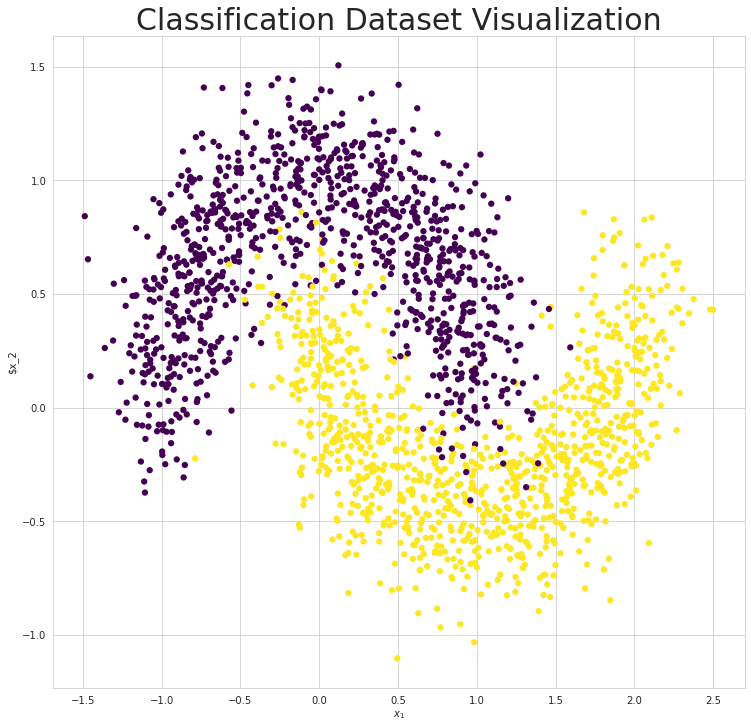

In [3]:
# visualize dataset
def plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=None):
    if dark:
        plt.style.use("dark_background")
    else:
        sns.set_style("whitegrid")
        
    plt.figure(figsize=(16, 12))
    
    axes = plt.gca()
    axes.set(xlabel="$x_1$", ylabel="$x_2")
    
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=1)
        plt.contour(
            XX, YY, preds.reshape(XX.shape), levels=[.5], cmap=plt.get_cmap("viridis"), vmin=0, vmax=0.6
        )
    
    plt.scatter(X[:, 0,], X[:, 1], c=y.ravel(), s=40, edgecolors="None", cmap=plt.get_cmap("viridis"))

plot(X, y, "Classification Dataset Visualization")
plt.show()

In [4]:
# design layers

class Layer(object):
    def __init__(
        self, 
        n_input, 
        n_neurons, 
        activation=None, 
        weights=None, 
        bias=None
    ):
        self.weights = weights if weights else \
            np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias else np.random.rand(n_neurons) * 0.1
        self.activation = activation
        self.last_activation = None
        self.error = None
        self.delta = None
        
    def activate(self, x):
        z = x @ self.weights + self.bias
        self.last_activation = self._apply_activation(z)
        return self.last_activation
        
    def _apply_activation(self, z):
        if self.activation == "relu":
            return np.maximum(0, z)
        elif self.activation =="sigmoid":
            return 1 / (1 + np.exp(-z))
        elif self.activation == "tanh":
            return (np.exp(z) - np.exp(z)) / (np.exp(z) + np.exp(z))
        else:
            return z
    
    def _apply_activation_derivative(self, z):
        if self.activation == "relu":
            grad = np.copy(z)
            grad[grad>0] = 1
            grad[grad<=0] = 0
            return grad
        elif self.activation == "sigmoid":
            return z * (1 - z)
        elif self.activation == "tanh":
            return 1 - z**2
        else:
            return z

In [53]:
class Network(object):
    def __init__(self):
        self.layers: List[Layer] = []
    
    def add_layer(self, layer: Layer):
        self.layers.append(layer)
    
    def forward_propagation(self, x):
        for layer in self.layers:
            x = layer.activate(x)
        return x    

    def back_propagation(self, X, y, learning_rate):
        output = self.forward_propagation(X)
        for i in reversed(range(self.layers.__len__())):
            layer = self.layers[i]
            # 输出层计算
            if layer == self.layers[-1]:
                layer.error = y - output
                layer.delta = layer.error * layer._apply_activation_derivative(output)
            # 隐藏层计算
            else:
                next_layer = self.layers[i+1]
                print(f"第{i+1}层 weight: {next_layer.weights.shape} -- delta: {next_layer.delta.shape}")
                layer.error = next_layer.weights * next_layer.delta
                print(type(layer._apply_activation_derivative(layer.last_activation)))
                layer.delta =  layer._apply_activation_derivative(layer.last_activation) * layer.error
            
            o_i = np.atleast_2d(X if i==0 else self.layers[i-1].last_activation)
            layer.weights += layer.delta * o_i.T * learning_rate
            
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epoches):
        y_onehot = tf.one_hot(y_train, depth=2).numpy()
        mses = []
        for i in range(max_epoches):
            # only train one sample at one time
            for j in range(X_train.shape[0]):
                self.back_propagation(
                    X_train[j,:], y_onehot[j,:], learning_rate 
                )
            if i % 10 == 0:
                mse = np.mean(
                    np.square(
                        y_onehot - self.forward_propagation(x=X_train)
                    )
                )
                mses.append(mse)
                print(f"epoch: {i} -- MSE: {mse}")
        return mses
                

In [54]:
nn = Network()
nn.add_layer(Layer(2, 25, "sigmoid"))
nn.add_layer(Layer(25, 50, "sigmoid"))
nn.add_layer(Layer(50, 25, "sigmoid"))
nn.add_layer(Layer(25, 2, "sigmoid"))

nn.train(X_train, X_test, y_train, y_test, 0.01, 1000)

第3层 weight: (25, 2) -- delta: (2,)
<class 'numpy.ndarray'>


ValueError: operands could not be broadcast together with shapes (25,) (25,2) 